# Reject Option Classification

**Uses the Reject Option Classification post-processing algorithm from the AIF360 toolkit. This algorithm works by giving an unfavorable outcome to privileged groups and a favorable outcome for unprivileged groups in a confidence band around the decision boundary with the highest uncertainty.** https://aif360.readthedocs.io/en/latest/modules/algorithms.html

Based on the example found at https://github.com/IBM/AIF360/blob/master/examples/demo_reject_option_classification.ipynb

See http://aif360.mybluemix.net/resources#guidance for guidance on metrics and mitigation algorithms

https://github.com/cosmicBboy/themis-ml/blob/master/paper/main.pdf

### Definitions

**Favorable label:** The value considered favorable. Usually 1.0 as opposed to the unfavorable label: 0.1<br />
**Pre-processing algorithm:** Bias mitigation algorithm applied prior to the creation of the model.<br />
**In-processing algorithm:** Bias mitigation algorithm applied during training.<br />
**Post-processing algorithm:** Bias mitigation algorithm applied to predicted labels.<br />
**Equalized odds:** Instances have equal odds of being assigned to the positive group, regardless of which group they belong to (protected attribute). The use of the protected attribute is prohibitied in determining the outcome value.<br />
**Equal opportunity:** A weaker notion than equalized odds. It requires non-discrimination among the "advantaged" outcome group. In this case, those assigned to the positive class (employed).<br />


In [18]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import numpy as np
from tqdm import tqdm
from warnings import warn
import pandas as pd

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification
from common_utils import compute_metrics
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider

# Import employment dataset 
from EmploymentDataset import EmploymentDataset
from util import preprocess_employment

In [19]:
# Privileged, unprivileged groups (males and white are privileged, females and non whites are unprivileged)
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]

# Load dataset
dataset_orig = preprocess_employment(['Sex'])

# Measures the difference between favorable outcome for the unprivileged group to the privileged group
metric_name = "Average odds difference"

# Upper and lower bound of constraint on the metric value
metric_ub = 0.05
metric_lb = -0.05
        
#random seed for calibrated equal odds prediction
np.random.seed(1)

In [20]:
# Split into train and test (70% train, 15% validate & 15% train)
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

In [21]:
# Display dataset shape, privileged/unprivileged classes and attribute
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(56827, 42)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['Sex', 'Race', 'Region=0', 'Region=1', 'Region=2', 'Region=3', 'Married=0', 'Married=1', 'Married=2', 'Married=3', 'Married=4', 'Education=0', 'Education=1', 'Education=2', 'Education=3', 'Education=4', 'Education=5', 'Education=6', 'Education=7', 'Citizenship=Native', 'Citizenship=Non Native', 'Industry=0', 'Industry=1', 'Industry=2', 'Industry=3', 'Industry=4', 'Industry=5', 'Industry=6', 'Industry=7', 'Industry=8', 'Industry=9', 'Industry=10', 'Industry=11', 'Industry=12', 'Industry=13', 'age_by_decade=10', 'age_by_decade=20', 'age_by_decade=30', 'age_by_decade=40', 'age_by_decade=50', 'age_by_decade=60', 'age_by_decade=>=70']


**Original training data metrics**

In [22]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
display(Markdown('A value of 1 indicates full discrimination, while -1 is the reverse discrimination case. A value close to 0 is favorable. (1 - mean difference)'))
print(f'The difference in mean outcomes between unprivileged and privileged groups is { metric_orig_train.mean_difference():.6f}')

#### Original training dataset

A value of 1 indicates full discrimination, while -1 is the reverse discrimination case. A value close to 0 is favorable. (1 - mean difference)

The difference in mean outcomes between unprivileged and privileged groups is -0.095224


# Intuition

The privileged group gets 9.3% more favorable outcome than the unprivileged group in the training dataset. Thus, slight discrimination takes place. To mitigate for this, we're going to use the reject-option classification post-processing algorithm.

### Train classifier on original data

In [23]:
# Logistic regression classifier and predictions (sklearn)
scale_orig = StandardScaler()

# Standardize data to normal disrtibution, i.e transform columns to a common scale (numerical values)
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# index to positive class
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

# Get predictions and labels
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

**Obtain scores for validation and test sets**

In [24]:
# Same procedure, but for validation set
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal parameters from the validation set

**Best theroshold for classification (no fairness)**

In [25]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.8097
Optimal classification threshold (no fairness constraints) = 0.7326


**Estimate optimal parameters for the ROC method**

In [26]:
# Use upper and lower bound constraint for tweaking (metric_ub and metric_lb)
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_valid, dataset_orig_valid_pred)

In [27]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.7227
Optimal ROC margin = 0.0622


### Predictions from validation set

In [28]:
# Metrics for the test set
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

display(Markdown("#### Validation set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.8097
Statistical parity difference = -0.2117
Disparate impact = 0.7300
Average odds difference = -0.1292
Equal opportunity difference = -0.1832
Theil index = 0.1607


# Intution

Statistical parity is the difference (SPD) between the probability of an unprivileged instance being labeled 1 (employed) and an privileged instance being labeled 1. This means that, without any fairness constraints, an privilileged instance is 32% more likely to be assigned the employed class. An SPD close to 0 indicates fairness.

For the average odds measure, a value closer to 0 is favorable for fairness.

For disparate impact, a value closer to 1 is favorable. It is equal to the probability of an unprivileged instance getting a favorable outcome divided by the probability of an privileged class getting a favorable outcome.

For equal opportunity difference, a value closer to 0 is favorable. This simply states that, people with similar attributes, protected attributes aside, should be given an equal opportunity of being assigned to a positive class.

All of these, with the exception of disparate impact, have an ideal value of 0, with values between 0.1 and -0.1 indicating fairness. 

In [29]:
# Transform the validation set
dataset_transf_valid_pred = ROC.predict(dataset_orig_valid_pred)

display(Markdown("#### Validation set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.8037
Statistical parity difference = -0.1302
Disparate impact = 0.8295
Average odds difference = -0.0459
Equal opportunity difference = -0.1037
Theil index = 0.1466


In [30]:
# Testing: Check if the metric optimized has not become worse
assert np.abs(metric_valid_aft[metric_name]) <= np.abs(metric_valid_bef[metric_name])

### Predictions from Test set

In [31]:
# Metrics for the test set
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label


display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.8014
Statistical parity difference = -0.2203
Disparate impact = 0.7219
Average odds difference = -0.1388
Equal opportunity difference = -0.1803
Theil index = 0.1637


[0.         0.         0.         ... 0.99690828 0.99828238 1.        ]
[0.00000000e+00 3.23729362e-04 1.18700766e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[1.99723471e+00 9.97234706e-01 9.96326960e-01 ... 4.43070639e-02
 3.91630101e-02 4.75594632e-05]
<class 'numpy.float64'>


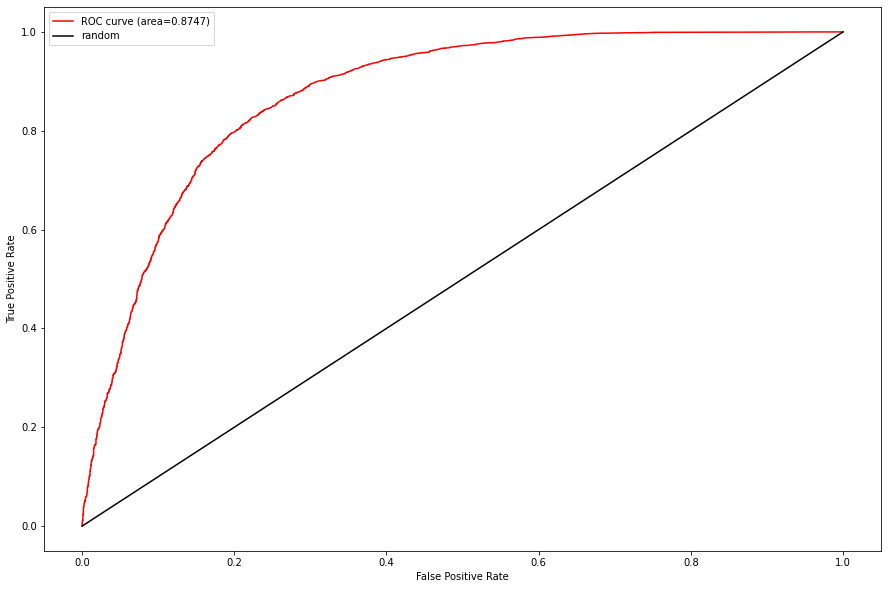

In [32]:
fpr, tpr, thresholds = roc_curve(dataset_orig_test.labels, dataset_orig_test_pred.scores)
print(f'{fpr}\n{tpr}\n{thresholds}')

fpr_RF, tpr_RF, thresholds_RF = roc_curve(dataset_orig_test.labels, dataset_orig_test_pred.scores, pos_label=1)

print(type(fpr_RF[0]))
plt.figure(figsize=(15, 10))
plt.plot(fpr_RF, tpr_RF,'r-',label = f'ROC curve (area={round(roc_auc_score(dataset_orig_test.labels, dataset_orig_test_pred.scores), 4)})')
plt.plot([0,1],[0,1],'k-',label='random')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("roc_curve_reject_option.svg")
plt.show()
### ROC END

In [33]:
827# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)






metric_orig_pred = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print(f'The difference in mean outcomes between unprivileged and privileged groups is { metric_orig_pred.mean_difference():.6f}')

#### Test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.7957
Statistical parity difference = -0.1348
Disparate impact = 0.8250
Average odds difference = -0.0542
Equal opportunity difference = -0.0939
Theil index = 0.1494
The difference in mean outcomes between unprivileged and privileged groups is -0.134816


[0.         0.         0.         ... 0.99690828 0.99828238 1.        ]
[0.00000000e+00 3.23729362e-04 1.18700766e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[1.99723471e+00 9.97234706e-01 9.96326960e-01 ... 4.43070639e-02
 3.91630101e-02 4.75594632e-05]


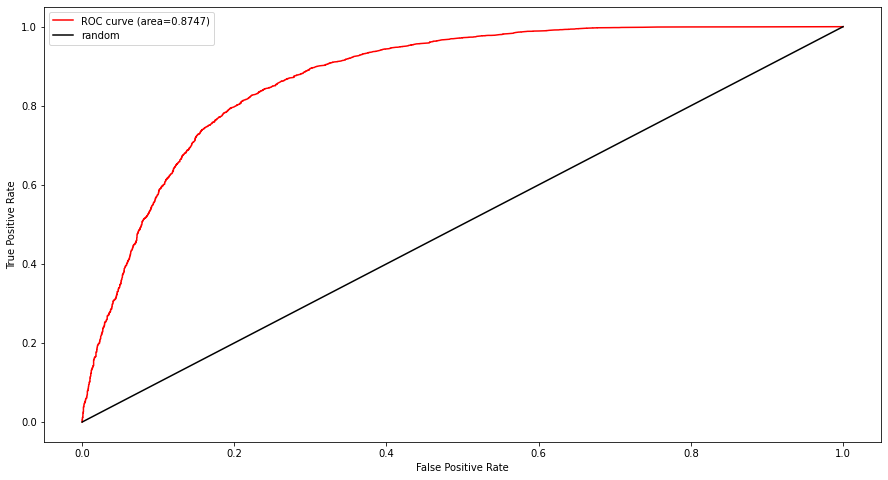

In [34]:
fpr, tpr, thresholds = roc_curve(dataset_orig_test.labels, dataset_transf_test_pred.scores)
print(f'{fpr}\n{tpr}\n{thresholds}')

fpr_RF, tpr_RF, thresholds_RF = roc_curve(dataset_orig_test.labels, dataset_transf_test_pred.scores, pos_label=1)

plt.figure(figsize=(15,8))
plt.plot(fpr_RF, tpr_RF,'r-',label = f'ROC curve (area={round(roc_auc_score(dataset_orig_test.labels, dataset_transf_test_pred.scores), 4)})')
plt.plot([0,1],[0,1],'k-',label='random')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
### ROC END